# Image classification with a Convolutional Neural Network

## 1. Importing Libraries <a id="cnn">

In [6]:
#Sequential model.
from keras.models import Sequential
from keras.layers import Activation, Dense

#Getting necessary layers.
from keras.layers import Conv2D             #Two-dimensional convolution layer.
from keras.layers import MaxPooling2D       #Two-dimensional pooling layer.
from keras.layers import Flatten            #Flattening layer.
from keras.layers import Dropout            #Regularization to prevent overfitting.
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model, model_to_dot
from keras import regularizers

#Image preprocessing.
from keras.preprocessing.image import ImageDataGenerator       
from keras.preprocessing import image

#Operating system interface.
import os

#Plotting library.
import matplotlib.pyplot as plt
from livelossplot.tf_keras import PlotLossesCallback
from IPython.display import SVG, Image

#Other libraries.
import numpy as np
import random
import PIL

## 2. Construction the CNN <a id="cnn">

In [3]:
# Initialising the CNN
model = Sequential()

# 1st Convolution Layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=(128, 128, 3), kernel_regularizer = regularizers.l1(0.00022)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same', kernel_regularizer = regularizers.l1(0.00023)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
#model.add(Conv2D(256,(3,3), padding='same'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

# 4th Convolution layer
#model.add(Conv2D(512,(3,3), padding='same'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(64, kernel_regularizer = regularizers.l1(0.00022)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Fully connected layer 2nd layer
model.add(Dense(128, kernel_regularizer = regularizers.l1(0.00023)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

opt = Adam(lr=0.00001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 128)      

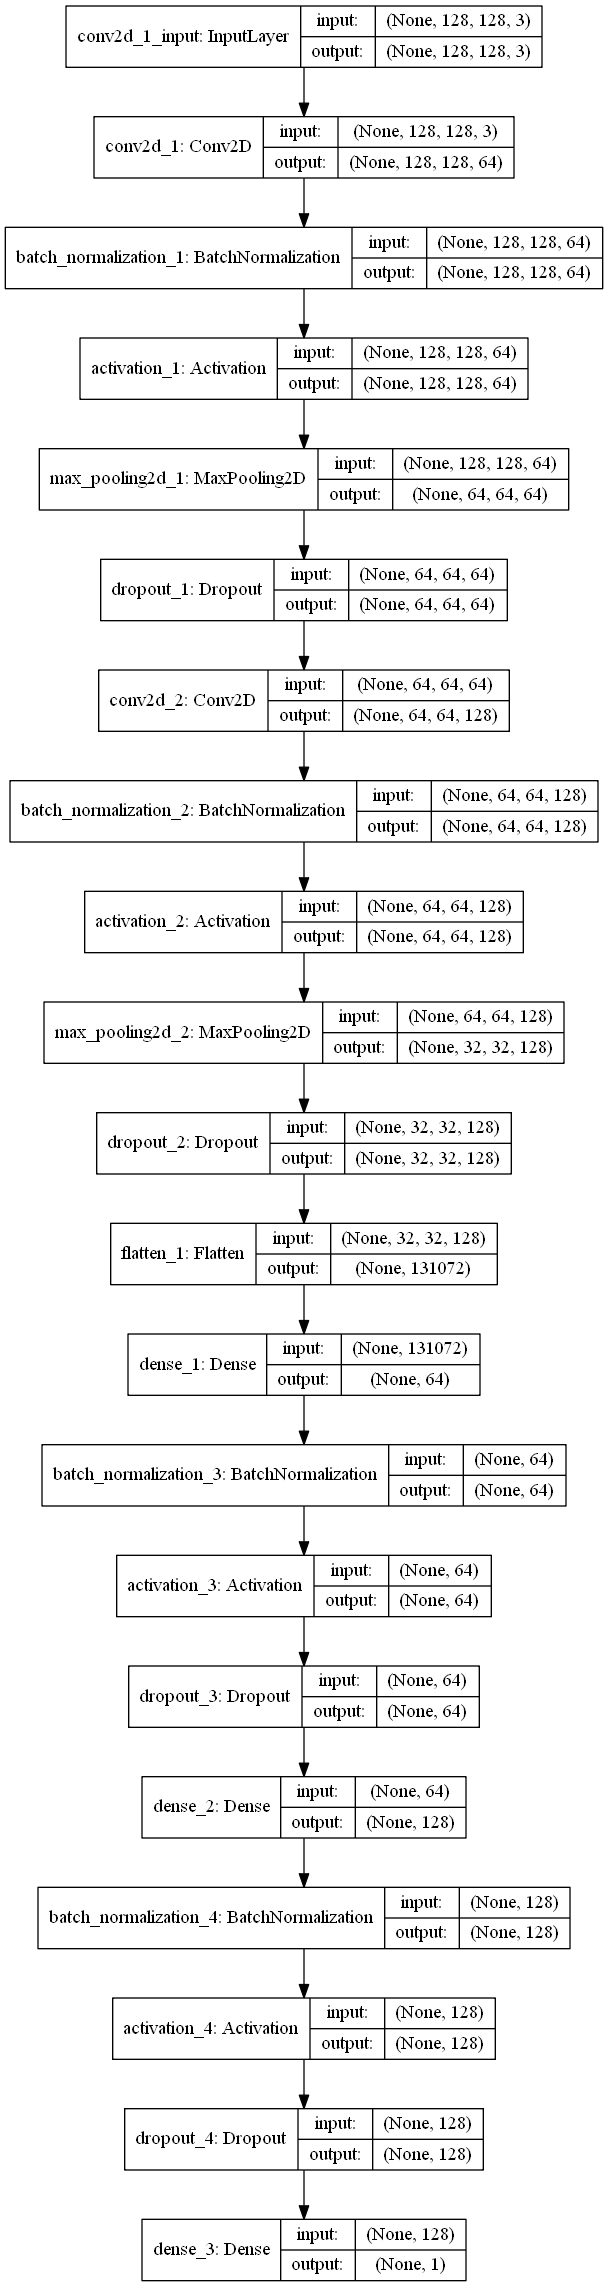

In [11]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=200)

## 3. Training & Evaluation<a id="tt">

In [38]:
train_images = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

Next, we label images.

In [39]:
path = 'Segmented'

def makeLabeledFolders(path, label):
    folder_path = path+"/"+label+"/"
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    for f in os.listdir(path):
        if f.endswith(".jpg") and f.startswith(label):
            os.rename(path+"/"+f, folder_path+f)

makeLabeledFolders(path, "no")
makeLabeledFolders(path, "yes")

We construct a training set of images and a test set of images.

In [40]:
training_set = train_images.flow_from_directory("Segmented", target_size = (128, 128), batch_size = 32, class_mode = 'binary', subset='training')
test_set = train_images.flow_from_directory("Segmented", target_size = (128, 128), batch_size = 32, class_mode = 'binary', subset='validation')

Found 1377 images belonging to 2 classes.
Found 344 images belonging to 2 classes.


We train our classifying model.

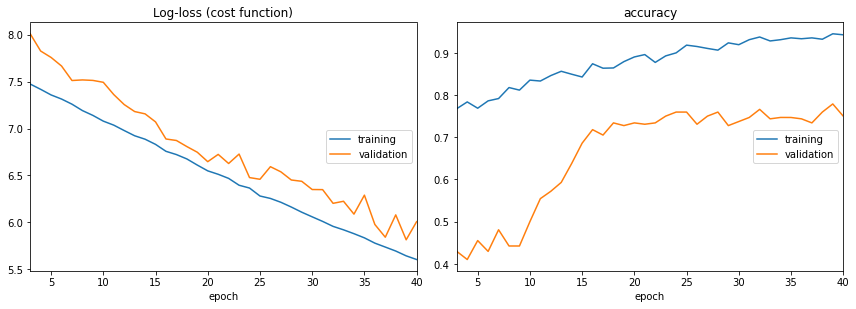

Log-loss (cost function):
training   (min:    5.605, max:    7.595, cur:    5.605)
validation (min:    5.815, max:    8.009, cur:    6.008)

accuracy:
training   (min:    0.746, max:    0.945, cur:    0.943)
validation (min:    0.410, max:    0.779, cur:    0.750)

Epoch 00040: saving model to model_weights.h5


In [42]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]
history = model.fit_generator(training_set, steps_per_epoch = 30, epochs = 40, validation_data=test_set, validation_steps=10, callbacks=callbacks)

In [36]:
model.load_weights("model_weights.h5")

In [40]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)